levels: (1.0, 4.000025616066397, 16.00133224021316, 64.03523110210436, 256.7025634338404, 1030.7778757460662, 4144.657894736842, 18119.625)
Y_prob: tensor([[0.0010, 0.2895, 0.9566]], device='cuda:0', grad_fn=<SigmoidBackward0>)
(72672,)
saving...


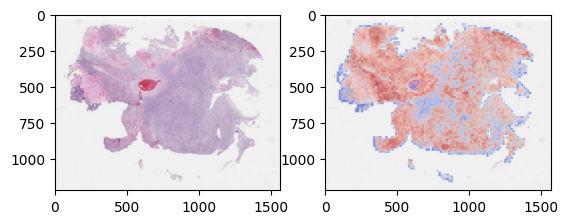

In [16]:
import torch
import h5py
import openslide
from PIL import Image
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import matplotlib.pyplot as plt
# from models.AMIL_MOE import AMIL_MOE
from models.AMIL_multi import MultiscaleMoEAMIL
import torch
import numpy as np
import cv2

import imageio


# 828156-3 BCL2
# 
name = '922593-8' # slide_id
label = 'BCL6'     # lsabel
save_flag = True
cls_channel = 2
level_ = -5
topk = 50
h5_root = '/data3/ceiling/workspace/DLBCL2/features/'
wsi_root = '/data3/ceiling/workspace/DLBCL2/features/'
patch_size = 224
save_path = './visualization/AMIL_MOE_Sampling/TCH/' + name + '_{}'.format(label) + '/'
save_high_attn = './comparison/AMIL_MOE_Sampling/TCH/' + name + '_{}'.format(label) + '/high_attn_{}/'.format(label)
save_low_attn = './comparison/AMIL_MOE_Sampling/TCH/' + name + '_{}'.format(label) + '/low_attn_{}/'.format(label)
save_high_attn_flag = True
save_low_attn_flag = True

if os.path.exists(save_path) is False:
    os.makedirs(save_path)
if save_high_attn_flag:
    os.makedirs(save_high_attn, exist_ok=True)
if save_low_attn_flag:
    os.makedirs(save_low_attn, exist_ok=True)

model = MultiscaleMoEAMIL(n_classes=3)

# ckpt_path = './save_weights/TCH_5fold_MYC_896_moe_{}_sampling/s_0_checkpoint_28.pt'.format(label)
ckpt_path = './save_weights/s_0_checkpoint.pt'
# CKPT_PATH  = './save_weights/Five_5fold_mutation_896_moe_bce555/s_0_checkpoint.pt'

ckpt = torch.load(ckpt_path)

model.load_state_dict(ckpt, strict=True)
model = model.cuda()
model.eval()

h5_path = os.path.join(h5_root, name + '.h5')
wsi_path = os.path.join(wsi_root, name + '.svs')

# read feature file
file = h5py.File(h5_path, 'r')
features = file['features']
coords = file['coords']

# read wsi
slide = openslide.open_slide(wsi_path)
width, height = slide.dimensions
levels = slide.level_downsamples
print("levels:", slide.level_downsamples)
w = int(width // levels[level_])
h = int(height // levels[level_])
image = slide.read_region((0, 0), len(levels) + level_, (w, h))
image = np.array(image)[:, :, :3]

tensor = torch.from_numpy(np.array(features)).cuda()
# classes, prediction_bag, A, B
logits, Y_prob, Y_hat, A_raw, results_dict, gate_weight_list = model(tensor)
print('Y_prob:', Y_prob)
# A_raw = torch.softmax(A_raw, dim=-1)
# B = torch.tanh(B)
A_raw = A_raw.detach().cpu().numpy()[cls_channel]
print(A_raw.shape)

if save_high_attn_flag:
    _, indices = torch.topk(torch.tensor(A_raw), k=topk, dim=0)
    for i in indices:
        coord = coords[i.item()]
        patch = slide.read_region((coord[1], coord[0]), 0,
                                  (patch_size, patch_size))
        imageio.imwrite(os.path.join(save_high_attn, '{}_{}.png'.format(coord[0], coord[1])), patch)
        
if save_low_attn_flag:
    _, indices = torch.topk(torch.tensor(-A_raw), k=topk, dim=0)
    for i in indices:
        coord = coords[i.item()]
        patch = slide.read_region((coord[1], coord[0]), 0,
                                  (patch_size, patch_size))
        imageio.imwrite(os.path.join(save_low_attn, '{}_{}.png'.format(coord[0], coord[1])), patch)
attn = np.zeros((h, w))
mask = np.zeros((h, w, 1), dtype=np.uint8)

size = patch_size // int(levels[level_])
for step, value in enumerate(coords):
    i, j = value
    i = i // int(levels[level_])
    j = j // int(levels[level_])
    mask[j:j+size*2, i:i+size*2] = 1
    value = (A_raw[step] - A_raw.min()) / (A_raw.max() - A_raw.min())
    attn[j:j+size*2, i:i+size*2] = value
    

import cmapy
attn_map = np.uint8(255 * attn)
# attn_blur = attn_map
attn_blur = cv2.blur(attn_map, (2 * size, 2 * size))
alpha = 0.40

colormap = 'coolwarm'

attn_color = cmapy.colorize(attn_blur, colormap, rgb_order=True)
attn_color = image * (1 - mask) + attn_color * mask
image_color = np.uint8(alpha * image + (1 - alpha) * attn_color)
attn = np.expand_dims(attn, 2)
fusion = (attn == 0) * image + (attn > 0) * image_color
print('saving...')
if save_flag:
    imageio.imwrite(save_path + 'image.png', image)
    imageio.imwrite(save_path + 'attn.png', attn_blur)
    imageio.imwrite(save_path + 'attn_map.png', attn_map)
    imageio.imwrite(save_path + 'colored.png', image_color)
    imageio.imwrite(save_path + 'fusion.png', fusion)

plt.subplot(121)
plt.imshow(image)
plt.subplot(122)
plt.imshow(fusion)
plt.show()


In [8]:
import torch
_, indices = torch.topk(torch.tensor(A_raw), k=10, dim=0)

In [17]:
save_high_attn, '{}_{}.png'.format(coord[0], coord[1])

('./comparison/AMIL_MOE_Sampling/TCH/1167412-6/high_attn/', '11424_51169.png')

In [4]:
from models.AMIL_multi import MultiscaleMoEAMIL
import torch
model = MultiscaleMoEAMIL(n_classes=3)
ckpt_path = '/data/ceiling/workspace/DLBLC/save_weights/BH_TCH_5fold_mutation_896_moe_bce555_fold3/s_3_checkpoint_30.pt'
ckpt = torch.load(ckpt_path)
model.load_state_dict(ckpt, strict=True)
logits, Y_prob, Y_hat, A_raw, results_dict, gate_weight_list = model(inputs)


In [3]:
from PIL import Image
import os

def split_image(image_path, rows, cols, output_dir='/data/ceiling/workspace/DLBLC/region-patches'):
    # 打开图像
    image = Image.open(image_path)
    width, height = image.size

    # 计算每块的尺寸
    tile_width = width // cols
    tile_height = height // rows

    # 创建输出目录
    os.makedirs(output_dir, exist_ok=True)

    # 切割图像
    for row in range(rows):
        for col in range(cols):
            left = col * tile_width
            upper = row * tile_height
            right = (col + 1) * tile_width
            lower = (row + 1) * tile_height

            tile = image.crop((left, upper, right, lower))

            # 如果是RGBA（带透明通道），转换为支持透明的PNG
            tile_path = os.path.join(output_dir, f'tile_{row}_{col}.png')
            tile.save(tile_path)

    print(f'图像已保存到 "{output_dir}" 目录下，共 {rows*cols} 块。')

# 示例用法
split_image('/data/ceiling/workspace/DLBLC/region-patches/Region.png', 4, 4)

图像已保存到 "/data/ceiling/workspace/DLBLC/region-patches" 目录下，共 16 块。


# 批量化保存

In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Batch Visualisation of DLBCL WSIs

依赖:
    pip install pandas h5py openslide-python imageio cmapy matplotlib

把本文件保存为 batch_vis.py
"""

# ------------------------- 配置区 -------------------------
CSV_PATH   = './dataset_csv/TCH_with_mutation.csv'        # 病例列表
H5_ROOT    = '/data/ceiling/data/DLBCL/Centers/BH_TCH/uni_scales/h5_files/'
WSI_ROOT   = '/data/ceiling/data/DLBCL/WSI/TCH/'
CKPT_PATH  = './save_weights/Five_5fold_mutation_896_moe_bce555/s_0_checkpoint.pt'

PATCH_SIZE = 224
LEVEL      = -5           # 与单张脚本的 level_ 相同
SAVE_DIR   = './visualization/AMIL_MOE_Sampling/TCH/'
TOPK       = 50           # 若需导出 topk patch
SAVE_HIGH_ATTN = False
SAVE_LOW_ATTN  = False
USE_CENTER = False        # coords 是否存中心点? 若是, 设 True

# 模型输出通道顺序 → 标签名
LABEL2CHAN = {'BCL2': 0, 'MYC': 1, 'BCL6': 2}
# --------------------------------------------------------

import os, pathlib, warnings
import numpy as np
import pandas as pd
import torch, h5py, openslide, imageio, cv2, cmapy
import matplotlib.pyplot as plt
from models.AMIL_multi import MultiscaleMoEAMIL  # 你的模型文件


# ============ 工具函数 ============

def load_model(ckpt_path: str) -> torch.nn.Module:
    model = MultiscaleMoEAMIL(n_classes=len(LABEL2CHAN))
    ckpt  = torch.load(ckpt_path, map_location='cpu')
    model.load_state_dict(ckpt, strict=True)
    model.cuda().eval()
    return model


def dump_patches(slide, coords, idxs, out_dir, size=224):
    out_dir.mkdir(parents=True, exist_ok=True)
    for k in idxs:
        x, y = coords[k]                         # coords = (x, y)
        patch = slide.read_region((int(x), int(y)), 0, (size, size))
        imageio.imwrite(out_dir / f'{y}_{x}.png', patch)
    print(f'   ↳ patches saved to {out_dir}')


def visualise_slide(slide_id: str,
                    label: str,
                    model: torch.nn.Module):
    """生成一张 slide-label 的注意力图"""
    chan = LABEL2CHAN[label]
    save_path = pathlib.Path(SAVE_DIR) / f'{slide_id}_{label}'
    save_path.mkdir(parents=True, exist_ok=True)

    h5_path  = pathlib.Path(H5_ROOT) / f'{slide_id}.h5'
    wsi_path = pathlib.Path(WSI_ROOT) / f'{slide_id}.svs'
    if not (h5_path.exists() and wsi_path.exists()):
        warnings.warn(f'[Skip] missing file: {h5_path} / {wsi_path}')
        return

    # ---------- 读取特征 ----------
    with h5py.File(h5_path, 'r') as f:
        feats  = torch.from_numpy(f['features'][()]).cuda()
        coords = f['coords'][()]                 # (N, 2)  (x, y)

    # ---------- 推理 ----------
    with torch.no_grad():
        _, _, _, A_raw, _, _ = model(feats)
    attn_vec = A_raw[chan].detach().cpu().numpy()    # (N,)

    # ---------- 打开 WSI ----------
    slide = openslide.open_slide(str(wsi_path))
    level_idx = slide.level_count + LEVEL            # LEVEL < 0
    factor    = slide.level_downsamples[level_idx]   # float!
    w, h      = slide.level_dimensions[level_idx]

    whole = slide.read_region((0, 0), level_idx, (w, h))
    whole = np.array(whole)[:, :, :3]

    # ---------- 生成热力图 ----------
    tile = int(round(PATCH_SIZE / factor))
    attn = np.zeros((h, w), dtype=np.float32)
    mask = np.zeros((h, w), dtype=np.uint8)

    vmin, vmax = attn_vec.min(), attn_vec.max()
    norm = (attn_vec - vmin) / (vmax - vmin + 1e-6)

    half = PATCH_SIZE / 2.0
    for (x_big, y_big), score in zip(coords, norm):
        if USE_CENTER:              # 若 coords 为中心点
            x_big -= half
            y_big -= half
        i = int(round(x_big / factor))          # 列
        j = int(round(y_big / factor))          # 行
        j_end = min(j + tile, h)
        i_end = min(i + tile, w)
        attn[j:j_end, i:i_end] = score
        mask[j:j_end, i:i_end] = 1

    attn_u8   = np.uint8(attn * 255)
    attn_blur = cv2.blur(attn_u8, (4*tile, 4*tile))
    attn_rgb  = cmapy.colorize(attn_blur, 'coolwarm', rgb_order=True)

    alpha = 0.40
    fusion = whole * (1 - mask[..., None]) + \
             (alpha*whole + (1-alpha)*attn_rgb) * mask[..., None]
    fusion = fusion.astype(np.uint8)

    # ---------- 保存 ----------
    imageio.imwrite(save_path / 'image.png',   whole)
    imageio.imwrite(save_path / 'attn.png',    attn_blur)
    imageio.imwrite(save_path / 'colored.png', fusion)
    print(f'[Done] {slide_id} – {label}')

    # ---------- 可选：保存 top-k patch ----------
    if SAVE_HIGH_ATTN or SAVE_LOW_ATTN:
        scores = torch.tensor(attn_vec)
        if SAVE_HIGH_ATTN:
            _, idxs = torch.topk(scores, TOPK)
            dump_patches(slide, coords, idxs, save_path/'high', PATCH_SIZE)
        if SAVE_LOW_ATTN:
            _, idxs = torch.topk(-scores, TOPK)
            dump_patches(slide, coords, idxs, save_path/'low', PATCH_SIZE)


# ======================= 主程序 ==========================
def main():
    df = pd.read_csv(CSV_PATH, sep=None, engine='python')
    model = load_model(CKPT_PATH)

    targets = list(LABEL2CHAN.keys())
    for _, row in df.iterrows():
        slide_id = str(row['slide_id'])
        for lbl in targets:
            if int(row[lbl]) == 1:
                visualise_slide(slide_id, lbl, model)


if __name__ == '__main__':
    os.makedirs(SAVE_DIR, exist_ok=True)
    main()

[Done] 21-13288 – BCL6
[Done] 1149358-1 – BCL6
[Done] T24-3746 – BCL6
[Done] 1012546-1 – MYC
[Done] 24-00937 – BCL6
[Done] 756879-1 – BCL2
[Done] 1027726-1 – MYC
[Done] 828156-3 – BCL2
[Done] 1076880-1 – MYC
[Done] 1205226-1 – BCL6
[Done] 1127616-1 – MYC
[Done] 1119660-2 – MYC
[Done] 1125882-2 – BCL2
[Done] 1125882-2 – MYC
[Done] 1125882-2 – BCL6
[Done] 22-00903 – BCL2
[Done] 1045824-1 – BCL6
[Done] 1167412-6 – BCL2
[Done] 1127616-2 – MYC
[Done] 18-01663 – BCL6
[Done] 18-15954 – BCL6
[Done] 1114171-1 – MYC
[Done] 1126744-1 – MYC
[Done] 23-07238 – BCL6
[Done] 19-06778 – BCL6
[Done] 21-09132 – BCL6
[Done] 1064692-1 – BCL6
[Done] 1188783-2 – BCL6
[Done] 998388-1 – BCL6
[Done] 1209621-2 – BCL6
[Done] 1116368-1 – BCL2
[Done] 1000811-1 – BCL2
[Done] 24-02508 – BCL6
[Done] 1204160-2 – BCL6
[Done] 874693-1 – BCL2
[Done] 1086188-1 – BCL2
[Done] 23-00735 – BCL2
[Done] 23-00735 – BCL6
[Done] 1120154-1 – BCL6
[Done] 1109001-1 – MYC
[Done] 1109001-1 – BCL6
[Done] 1153700-1 – BCL6
[Done] 907036-1 – 

KeyboardInterrupt: 